# Forecasting inflation rate of Peru

**Author**: Valerie Dube

**Date**  : April, 2024

P: Qué problema resuelves prediciendo mejor?

Añadir: Predicción en contexto de mayor o menor variabilidad en otros países de LATAM (Chile, Colombia, Arg?, Brazil...)

Heterogeneidad de distintos estudios es explicado por...?

Cuánto de la inflación es explicado por la producción (para países mineros debería ser mayor...) 

In [1]:
# Basic libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats

# Statsmodels
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from MacroRandomForest import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 1. Data extraction and database construction

#### 1.1. Features transformation

Transformation 1: Complete inflation expectations missings

In [2]:
inflacion_exp = pd.read_excel(r"./data/inflation_expectations.xlsx")

# Impute the missing values using the spline technique
inflacion_exp['inflacion_exp_spline'] = inflacion_exp['inflacion_exp'].interpolate(option='spline')

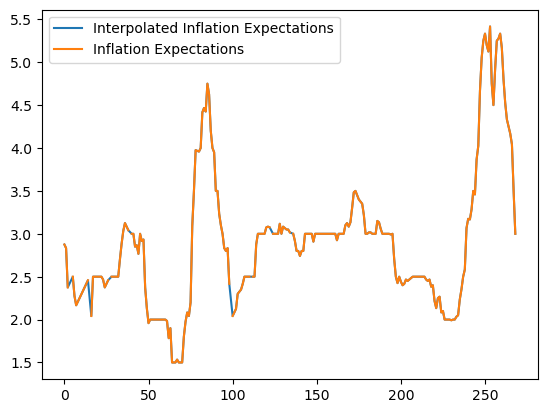

In [3]:
plt.plot(inflacion_exp.index, inflacion_exp['inflacion_exp_spline'], label='Interpolated Inflation Expectations')
plt.plot(inflacion_exp.index, inflacion_exp['inflacion_exp'], label='Inflation Expectations')

plt.legend()
plt.show()

In [4]:
# Save transformed data to Excel file
inflacion_exp['inflacion_exp_spline'].to_excel("./data/inflation_expectations_trans.xlsx")

Transformation 2: Upsampling private consumption, from quarterly to monthly frequency

In [13]:
consumo = pd.read_excel(r"./data/private_consumption_Q.xlsx")

# Convert 'Date' column to datetime object and set as index
consumo['Date'] = pd.to_datetime(consumo['Date'])
consumo = consumo.set_index('Date')

# Resample to monthly frequency, using the mean to aggregate and interpolate missing values
consumo_resamp = consumo.resample('M').mean().interpolate('linear')

# Export to Excel file
consumo_resamp.to_excel("./data/private_consumption_M.xlsx")

#### 1.2. Uploading raw database

In [15]:
# Read Excel file
raw_df = pd.read_excel(r"./data/raw_database.xlsx", sheet_name=0)

#### 1.3. Transform data

? Duda: Es necesario eliminar la estacionalidad? En algunos papers no lo hacen, pero no dan razón de si es mejor o no

? Duda: Cuando trabajar con el log o con la diferencia (qué tets hacer?)

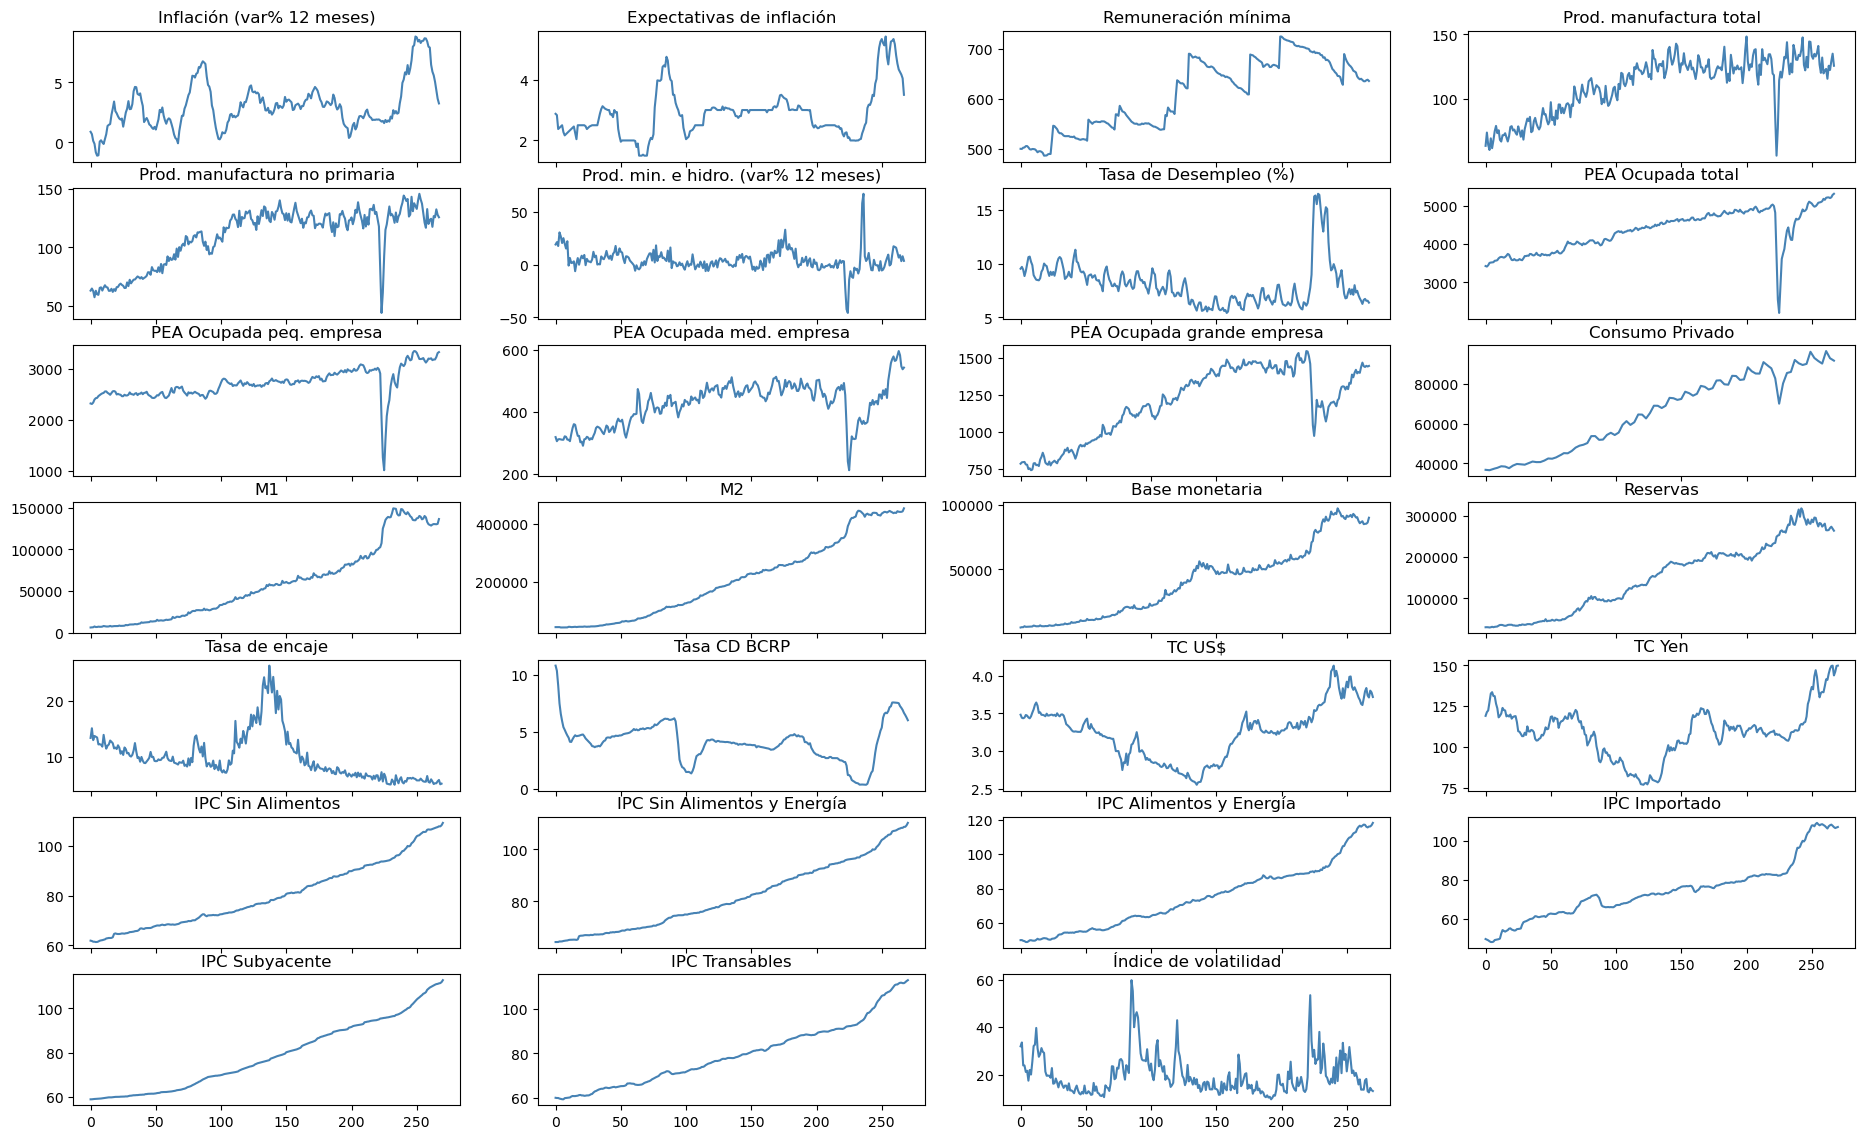

In [16]:
# Graph of parameters
raw_df.iloc[:, 1:].plot(kind ='line',
            subplots = True,
            figsize = (23,16),
            title = ['Inflación (var% 12 meses)', 'Expectativas de inflación','Remuneración mínima','Prod. manufactura total','Prod. manufactura no primaria',
                     'Prod. min. e hidro. (var% 12 meses)', 'Tasa de Desempleo (%)', 'PEA Ocupada total', 'PEA Ocupada peq. empresa', 'PEA Ocupada med. empresa',
                     'PEA Ocupada grande empresa','Consumo Privado','M1','M2','Base monetaria','Reservas', 'Tasa de encaje', 'Tasa CD BCRP', 'TC US$', 'TC Yen', 'IPC Sin Alimentos',
                     'IPC Sin Alimentos y Energía', 'IPC Alimentos y Energía', 'IPC Importado', 'IPC Subyacente', 'IPC Transables', 'Índice de volatilidad'],
            legend = False,
            layout = (8,4),
            sharex = True,
            color = 'steelblue')
plt.show()

#### 1.4. PCA: Esto todavía no

In [23]:
# # Calculate the PCA (only for 130 variables, transformed, not including lags)

# # 1. Standarize the data

# # 2. Calculate covariance matrix
# cov_mat = np.cov(df.iloc[5:, :].T) 

# # 3. Calculate the Eigenvalues and the Eigenvectors
# eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# # 4. Cumulative variance described by each component
# tot = sum(eigen_vals)
# var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# cum_var_exp = np.cumsum(var_exp)


In [24]:
# n_var = len(cum_var_exp) + 1

# # make a bar plot of the variance associated with each component
# import matplotlib.pyplot as plt

# plt.bar(range(1,n_var), var_exp, alpha=0.5, align='center',
#         label='Individual explained variance')
# plt.step(range(1,n_var), cum_var_exp, where='mid',
#          label='Cumulative explained variance',
#          color='red')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.show()

#### 1.5. Add lags

In [17]:
# Number of lags
n_column = raw_df.shape[1]
n_lags = 1

# Create lagged columns
for col in raw_df.columns[1:]:  # Exclude the first column (Date)
    for i in range(1, n_lags + 1):
        raw_df[f'{col}_lag{i}'] = raw_df[col].shift(i)

In [18]:
# Num of features (without lags)
n_features = n_column - 1

In [19]:
# Getting rid of the Nans
df = raw_df.iloc[n_lags:, [1] + list(range(n_features + 1, len(raw_df.columns)))].copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [20]:
df

,inflacion,inflacion_lag1,inflacion_exp_lag1,rem_min_lag1,pm_lag1,pm_np_lag1,p_minera_lag1,desempleo_lag1,pea_ocu_lag1,pea_ocu_pe_lag1,...,interes_cd_lag1,tc_us_lag1,tc_yen_lag1,IPC_sin_alim_lag1,IPC_sin_alim_ener_lag1,IPC_alim_ener_lag1,IPC_imp_lag1,IPC_subyacente_lag1,IPC_transables_lag1,VIX_lag1
0,0.678419,0.874859,2.875000,500.158990,63.224181,63.078229,19.018232,9.548051,3426.457,2320.468,...,10.797941,3.48150,118.975000,61.850849,64.343993,49.980907,49.450155,58.962831,60.037800,31.930000
1,0.118321,0.678419,2.833333,499.971617,73.576032,64.872062,21.238875,9.716332,3412.998,2310.718,...,10.348838,3.44065,121.281000,61.714829,64.353175,50.003308,49.129408,58.979150,59.943011,33.560001
2,-0.127352,0.118321,2.375000,502.448013,63.954572,62.711549,17.569666,9.451203,3447.438,2337.939,...,9.054864,3.43465,122.308000,61.436300,64.360959,49.582595,48.803224,59.069621,59.953974,23.840000
3,-0.832736,-0.127352,2.416667,502.908128,60.010244,57.421576,30.496972,8.861439,3509.056,2397.634,...,7.484538,3.44370,127.358000,61.432236,64.567970,49.399084,48.298783,59.118108,59.687798,23.799999
4,-1.114360,-0.832736,2.458333,505.536544,69.067893,62.982313,26.719937,9.324256,3517.826,2424.519,...,6.567064,3.47810,132.665000,61.298769,64.559454,48.906341,47.919767,59.157029,59.533687,21.090000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,5.576147,5.881601,4.525000,637.600657,115.474510,117.664449,11.459634,6.264338,5223.353,3170.979,...,7.538129,3.61060,141.026905,106.842719,107.613955,116.579878,106.329205,110.009745,110.875015,13.630000
263,5.044546,5.576147,4.333333,635.211420,125.607328,126.833618,6.651798,6.637680,5225.573,3182.624,...,7.506888,3.69600,144.891087,107.009951,107.875805,117.195239,107.485933,110.351191,111.320890,13.570000
264,4.343081,5.044546,4.250000,635.107245,122.336305,125.817836,8.938821,6.731353,5208.286,3184.061,...,7.254324,3.79260,147.891190,107.227388,108.019897,117.058489,108.028801,110.614019,111.625139,17.520000
265,3.636475,4.343081,4.166667,637.161757,129.268777,132.605188,3.248046,6.555003,5227.600,3231.500,...,7.102736,3.83650,149.599318,107.446093,108.257134,115.957814,108.343430,110.876495,111.661435,18.140000


#### 1.6. Splitting the data

In [37]:
# Delimitator
split_point = math.floor(len(df) * 0.80)

# Train data
X_train = df.iloc[:split_point, 1:].copy()
y_train = df.iloc[:split_point, 0].copy()

# Test data
X_test = df.iloc[split_point:, 1:].copy()
y_test = df.iloc[split_point:, 0].copy()

In [38]:
# Standardize the values of X
scale = StandardScaler()

X_train_scaled = scale.fit_transform(X_train) 
X_test_scaled = scale.transform(X_test)

### 2. Feature selection

In this section, we will see with which set of features the linear regression has better prediction (lower MAE). We will compare the model with 1) all variables, 2) manual selection (economics theory), 4) P-value, and 3) Lasso CV

Reference: Rezazadeh Kalehbasti, P., Nikolenko, L., & Rezaei, H. (2021, August)

#### 2.1. All features

In [39]:
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_pred = lm.predict(X_test_scaled)

In [40]:
# Metricas de desempeño del modelo
all_features_corr = pearsonr(y_test, y_pred)[0]
all_features_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {all_features_corr:.4f}")
print(f"R^2 on validation: {all_features_r2:.4f}")

Correlación: 0.9382
R^2 on validation: 0.8394


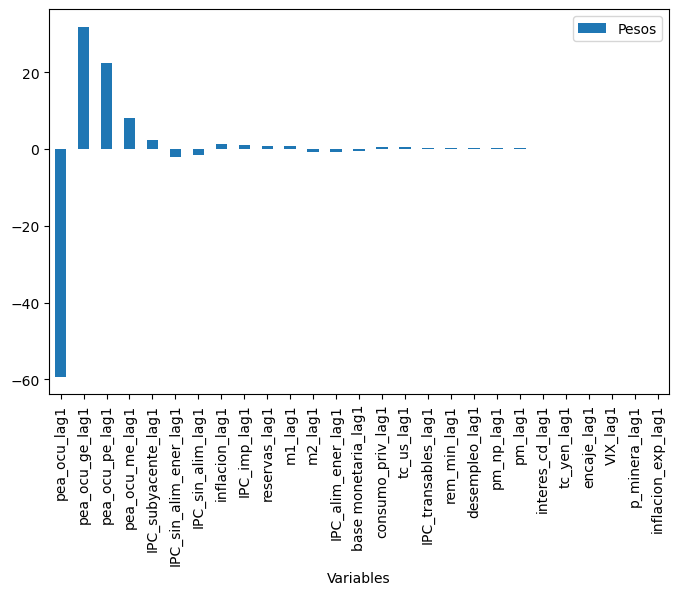

In [41]:
# Visualizo los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lm.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (8, 5))
plt.show()

#### 2.2. Manual selection

In [42]:
# List of features according to economic literature
# Ajustar el modelo a los datos
lm = LinearRegression()
lm.fit(X_train_scaled[:, [0, 11, 16]], y_train) # inflation lag, consumo priv lag, encaje lag, 
y_pred = lm.predict(X_test_scaled[:, [0, 11, 16]])

In [43]:
# Metricas de desempeño del modelo
by_hand_corr = pearsonr(y_test, y_pred)[0]
by_hand_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {by_hand_corr:.4f}")
print(f"R^2 on validation: {by_hand_r2:.4f}")

Correlación: 0.9846
R^2 on validation: 0.9673


#### 2.3. P-value selection

In [44]:
# Fit and summarize OLS model
mod = sm.OLS(y_train, X_train_scaled)
res = mod.fit()
print(res.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                                 OLS Regression Results                                
Dep. Variable:              inflacion   R-squared (uncentered):                   0.224
Model:                            OLS   Adj. R-squared (uncentered):              0.112
Method:                 Least Squares   F-statistic:                              1.992
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                     0.00418
Time:                        13:37:05   Log-Likelihood:                         -513.01
No. Observations:                 213   AIC:                                      1080.
Df Residuals:                     186   BIC:                                      1171.
Df Model:                          27         

In [45]:
p_values = res.pvalues
alpha = 0.05

significant_features = []
for i, p_value in enumerate(p_values):
    if p_value < alpha:
        significant_features.append(i)

In [46]:
lm = LinearRegression()
lm.fit(X_train_scaled[:, significant_features], y_train)
y_pred = lm.predict(X_test_scaled[:, significant_features])

In [47]:
# Metricas de desempeño del modelo
pvalue_corr = pearsonr(y_test, y_pred)[0]
pvalue_r2 = r2_score(y_test, y_pred)
print(f"Correlación: {pvalue_corr:.4f}")
print(f"R^2 on validation: {pvalue_r2:.4f}")

Correlación: 0.9846
R^2 on validation: 0.9677


#### 2.4. Lasso selection

In [48]:
# cross validation TimeSeriesSplit 

In [49]:
# Se evalúan varias valores de lambda
lasso = LassoCV(alphas = np.arange(0.001, 0.01, 0.0001), cv = 10, max_iter = 5000)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [50]:
# Metricas de desempenho del modelo
lasso_ans_lambda = lasso.alpha_
lasso_r2 = r2_score(y_test, y_pred)

print(f"R^2 on validation: {lasso_r2:.4f}")
print(f"Mejor lambda: {lasso_ans_lambda:.4f}")

R^2 on validation: 0.9687
Mejor lambda: 0.0099


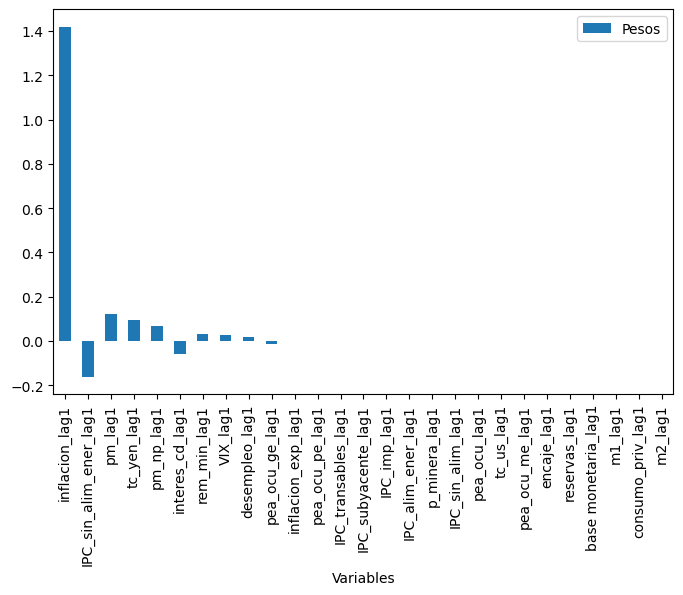

In [51]:
# Visualizo los pesos de cada variable
pd.DataFrame({"Variables": X_train.columns, "Pesos": lasso.coef_}). \
  sort_values(by = "Pesos", ascending = False, key = lambda x: abs(x)). \
  plot.bar(x = "Variables", y = "Pesos", figsize = (8, 5))
plt.show()

In [52]:
significant_features = [0, 3, 4, 8, 10, 16, 17, 19, 21, 23, 26]
lm = LinearRegression()
lm.fit(X_train_scaled[:, significant_features], y_train)

y_pred_train = lm.predict(X_train_scaled[:, significant_features])
y_pred_test = lm.predict(X_test_scaled[:, significant_features])

In [53]:
lasso_corr = pearsonr(y_test, y_pred)[0]

lr_mae_train = mean_absolute_error(y_train, y_pred_train)
lr_mse_train = mean_squared_error(y_train, y_pred_train)
lr_r2_train = r2_score(y_train, y_pred_train)

lr_mae_test = mean_absolute_error(y_test, y_pred)
lr_mse_test = mean_squared_error(y_test, y_pred)
lr_r2_test = r2_score(y_test, y_pred)

print(f"Correlación: {lasso_corr:.4f}")

print(f"MAE en entrenamiento: {lr_mae_train:.4f}")
print(f"MSE en entrenamiento: {lr_mse_train:.4f}")
print(f"R^2 on trainning: {lr_r2_train:.4f}")

print(f"MAE en validation: {lr_mae_test:.4f}")
print(f"MSE en validation: {lr_mse_test:.4f}")
print(f"R^2 on validation: {lr_r2_test:.4f}")

Correlación: 0.9879
MAE en entrenamiento: 0.2947
MSE en entrenamiento: 0.1398
R^2 on trainning: 0.9366
MAE en validation: 0.3571
MSE en validation: 0.2226
R^2 on validation: 0.9687


#### 2.5. Comparación de resultados

In [54]:
# Comparamos los 3 modelos
df_ans = pd.DataFrame({"All features": [all_features_corr, all_features_r2], \
                       "P-value": [pvalue_corr, pvalue_r2], \
                       "Lasso": [lasso_corr, lasso_r2]})
df_ans.index = ["Correlacion", "R2"]
df_ans

,All features,P-value,Lasso
Correlacion,0.938218,0.984557,0.98794
R2,0.839387,0.967669,0.96873


### 3. Models

In [55]:
selected_features = [0, 3, 4, 8, 10, 16, 17, 19, 21, 23, 26]

# Specify the columns you want to extract
X_train_scaled = X_train_scaled[:, selected_features]
X_test_scaled = X_test_scaled[:, selected_features]

#### 3.1. Ridge regression

In [56]:
# Se evalúan varias valores de lambda
ridge = RidgeCV(alphas = np.arange(1, 10, 0.5), cv = 10)
ridge.fit(X_train_scaled, y_train)

y_pred = ridge.predict(X_test_scaled)
y_pred_train = ridge.predict(X_train_scaled)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [57]:
ridge_ans_lambda = ridge.alpha_
print(f"Mejor lambda: {ridge_ans_lambda:.4f}")

Mejor lambda: 6.5000


In [58]:
# Metricas de desempenho del modelo
ridge_mae_train = mean_absolute_error(y_train, y_pred_train)
ridge_mse_train = mean_squared_error(y_train, y_pred_train)
ridge_r2_train = r2_score(y_train, y_pred_train)

ridge_mae_test = mean_absolute_error(y_test, y_pred)
ridge_mse_test = mean_squared_error(y_test, y_pred)
ridge_r2_test = r2_score(y_test, y_pred)

print(f"MAE en entrenamiento: {ridge_mae_train:.4f}")
print(f"MSE en entrenamiento: {ridge_mse_train:.4f}")
print(f"R^2 on trainning: {ridge_r2_train:.4f}")

print(f"MAE en validation: {ridge_mae_test:.4f}")
print(f"MSE en validation: {ridge_mse_test:.4f}")
print(f"R^2 on validation: {ridge_r2_test:.4f}")

MAE en entrenamiento: 0.3018
MSE en entrenamiento: 0.1445
R^2 on trainning: 0.9344
MAE en validation: 0.3336
MSE en validation: 0.2019
R^2 on validation: 0.9716


#### 3.2 Post-Lasso

In [59]:
# Hacer cross-validation para time series!!!

In [60]:
# Se evalúan varias valores de lambda
lasso = LassoCV(alphas = np.arange(0.01, 0.2, 0.0001), cv = 10, max_iter = 5000)
lasso.fit(X_train_scaled, y_train)
y_pred_train = lasso.predict(X_train_scaled)
y_pred = lasso.predict(X_test_scaled)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [61]:
lasso_ans_lambda = lasso.alpha_
print(f"Mejor lambda: {lasso_ans_lambda:.4f}")

Mejor lambda: 0.0634


In [62]:
lasso_mae_train = mean_absolute_error(y_train, y_pred_train)
lasso_mse_train = mean_squared_error(y_train, y_pred_train)
lasso_r2_train = r2_score(y_train, y_pred_train)

lasso_mae_test = mean_absolute_error(y_test, y_pred)
lasso_mse_test = mean_squared_error(y_test, y_pred)
lasso_r2_test = r2_score(y_test, y_pred)

print(f"MAE en entrenamiento: {lasso_mae_train:.4f}")
print(f"MSE en entrenamiento: {lasso_mse_train:.4f}")
print(f"R^2 on trainning: {lasso_r2_train:.4f}")

print(f"MAE en validation: {lasso_mae_test:.4f}")
print(f"MSE en validation: {lasso_mse_test:.4f}")
print(f"R^2 on validation: {lasso_r2_test:.4f}")

MAE en entrenamiento: 0.3310
MSE en entrenamiento: 0.1701
R^2 on trainning: 0.9228
MAE en validation: 0.4032
MSE en validation: 0.2791
R^2 on validation: 0.9608


#### 3.3 MRF

In [63]:
# var dependiente
y_pos = df.columns.get_loc('inflacion')

### Exogenous Variables
S_vars = df.drop(columns=['inflacion']).columns
S_pos = [df.columns.get_loc(s) for s in S_vars]

### Variables Included in Linear Equation
x_vars = ['inflacion_lag1', 'IPC_sin_alim_ener_lag1', 'pm_lag1', 'IPC_imp_lag1', 'pea_ocu_ge_lag1', 'tc_yen_lag1', 'interes_cd_lag1', 'VIX_lag1', 'encaje_lag1', 'pm_np_lag1', 'pea_ocu_pe_lag1']
x_pos = [df.columns.get_loc(x) for x in x_vars]



In [64]:
oos_pos = np.arange(len(df) - 24, len(df)) # Row positions of test set/out-of-sample observations

In [65]:
data = df.copy()

In [66]:
MRF = MacroRandomForest(data = data,
                        y_pos = y_pos,
                        x_pos = x_pos,
                        S_pos = S_pos,
                        B = 100,
                        parallelise = True,
                        n_cores = 3,
                        resampling_opt = 2,
                        oos_pos = oos_pos,
                        trend_push = 4,
                        quantile_rate = 0.3,
                        print_b = True,
                        ridge_lambda = 0.3,
                        fast_rw = True)

In [67]:
MRF_output = MRF._ensemble_loop()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
forecasts = MRF_output['pred']
betas = MRF_output['betas']

Text(0.5, 1.0, 'OOS predictions of MRF')

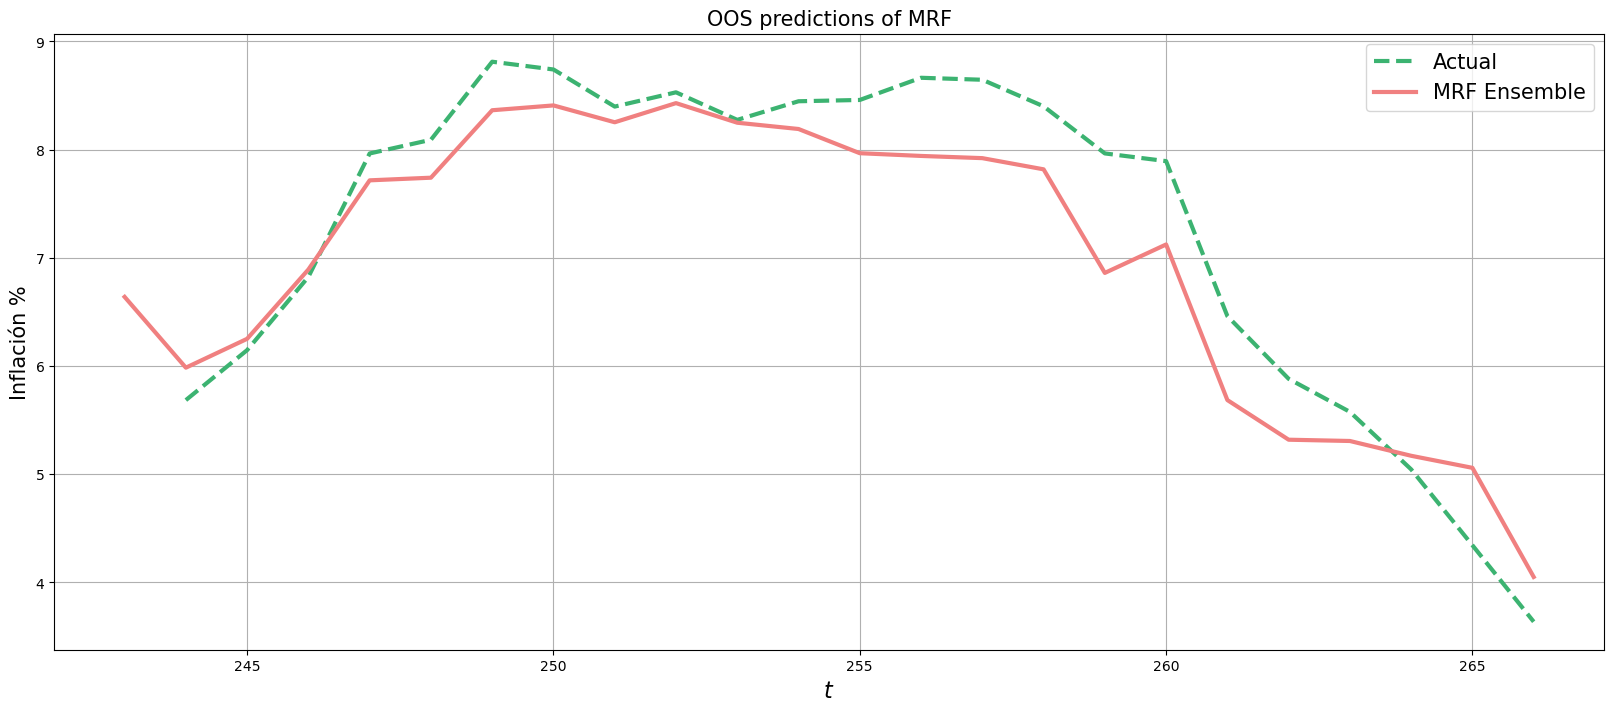

In [ ]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (20, 8)

# Plotting actual versus original
ax.plot(df['inflacion'].loc[oos_pos].shift(1), label = 'Actual', linewidth = 3, color ='mediumseagreen', linestyle = '--')
ax.plot(forecasts, color = 'lightcoral', linewidth = 3, label = "MRF Ensemble")

ax.legend(fontsize = 15)
ax.set_ylabel("Inflación %", fontsize = 15)
ax.grid()
ax.set_xlabel(r"$t$", fontsize = 16)
ax.set_title("OOS predictions of MRF", fontsize = 15)

MRF One-Step Macro Forecasting

In [ ]:
### Dependent Variable
my_var = "inflacion"
y_pos = df.columns.get_loc(my_var)

### Exogenous Variables
x_vars = ['inflacion_lag1']
x_pos = [df.columns.get_loc(x) for x in x_vars]

In [ ]:
oos_pos = np.arange(len(df) - 1, len(df))

In [ ]:
MRF = MacroRandomForest(data = df,
                     y_pos = y_pos,
                     x_pos = x_pos,
                     B = 100,
                     parallelise = True,
                     n_cores = 3,
                     resampling_opt = 2,
                     oos_pos = oos_pos,
                     trend_push = 6,
                     quantile_rate = 0.3,
                     ridge_lambda=0.001,
                     rw_regul=0.9,
                     print_b = True,
                     fast_rw = False)

In [ ]:
mrf_output = MRF._ensemble_loop()

Tree 1 out of 100
Tree 2 out of 100
Tree 3 out of 100
Tree 4 out of 100
Tree 5 out of 100
Tree 6 out of 100
Tree 7 out of 100
Tree 8 out of 100
Tree 9 out of 100
Tree 10 out of 100
Tree 11 out of 100
Tree 12 out of 100
Tree 13 out of 100
Tree 14 out of 100
Tree 15 out of 100
Tree 16 out of 100
Tree 17 out of 100
Tree 18 out of 100
Tree 19 out of 100
Tree 20 out of 100
Tree 21 out of 100
Tree 22 out of 100
Tree 23 out of 100
Tree 24 out of 100
Tree 25 out of 100
Tree 26 out of 100
Tree 27 out of 100
Tree 28 out of 100
Tree 29 out of 100
Tree 30 out of 100
Tree 31 out of 100
Tree 32 out of 100
Tree 33 out of 100
Tree 34 out of 100
Tree 35 out of 100
Tree 36 out of 100
Tree 37 out of 100
Tree 38 out of 100
Tree 39 out of 100
Tree 40 out of 100
Tree 41 out of 100
Tree 42 out of 100
Tree 43 out of 100
Tree 44 out of 100
Tree 45 out of 100
Tree 46 out of 100
Tree 47 out of 100
Tree 48 out of 100
Tree 49 out of 100
Tree 50 out of 100
Tree 51 out of 100
Tree 52 out of 100
Tree 53 out of 100
Tr

In [ ]:
MRF_output['pred']

,Ensembled_Prediction
217,1.941177
218,1.913100
219,1.930895
220,1.935053
221,1.955031
222,1.845822
223,1.715156
224,1.697555
225,1.593088
226,1.789808


### 4. Comparación de resultados

In [ ]:
# AIC y Bayesian